In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import metrics 

import json
import os
import pandas as pd

from util import gen_model_preds_df, report_metrics

with open('SWDA_dialogue-acts.json') as f:
    swda_tags = json.load(f, strict=False)
swda_tags_list = list(swda_tags)
with open('AMI-DA_dialogue-acts.json') as f:
    ami_tags = json.load(f, strict=False)
ami_tags_list = list(ami_tags)

## In-domain / cross-domain pre-training 
First we want to see how in-domain pre-training compares to cross domain pre-training.

In [2]:
conditions = ['in-domain', 'AMI+SWBD']

pre_corpora = ['SWBD-pre', 'AMI+SWBD-pre']
model_dirs = [f'../../models/SWDA-L_bert_{corpus}_2019-12-03/' for corpus in pre_corpora]
dfs = gen_model_preds_df('SWDA', conditions, model_dirs)

pre_corpora = ['AMI-pre', 'AMI+SWBD-pre']
model_dirs = [f'../../models/AMI-DA-L_bert_{corpus}_2019-12-03/' for corpus in pre_corpora]
dfa = gen_model_preds_df('AMI-DA', conditions, model_dirs)
dfa = dfa[dfa['da_tag'].notnull()]

report_metrics([dfs,dfa], conditions)

/Users/xnobwi/.virtualenvs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SWBD       AMI
in-domain macro precision  0.562046  0.523854
          macro recall     0.417171  0.453892
          macro f1         0.454760  0.465609
          micro accuracy   0.770237  0.686575
AMI+SWBD  macro precision  0.589477  0.543774
          macro recall     0.441669  0.469115
          macro f1         0.477812  0.487214
          micro accuracy   0.773529  0.685840

/Users/xnobwi/.virtualenvs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1511: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


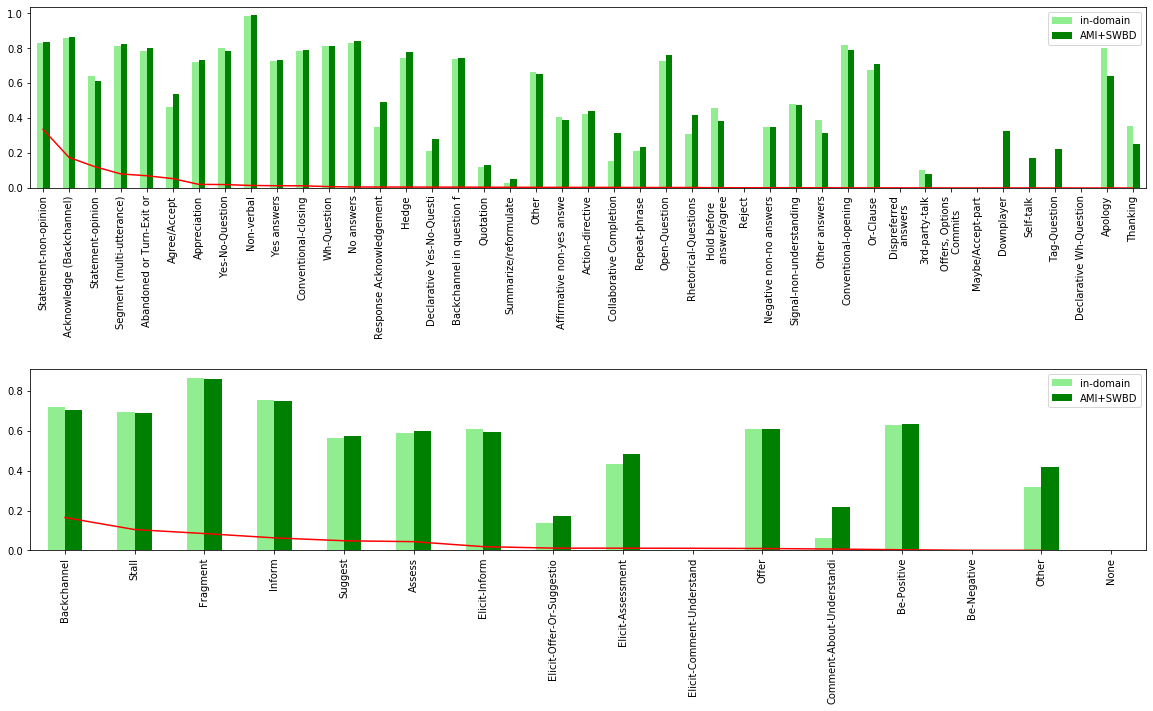

In [3]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.f1_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in conditions],
    index=conditions, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=['LightGreen', 'Green'])

res = pd.DataFrame([metrics.f1_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in conditions]
    , index=conditions, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=['LightGreen', 'Green'])

Pre-training on the combined corpus offers a modest improvement in macro-averaged F1 over simple in-domain pre-training, though there is little effect on micro-averaged performance.
This indicates that pre-training on the lareger, more diverse dataset is helpful for classification of lower-frequency tags. 
A larger pre-training corpus may lead to more significant gains.

In [4]:
conditions = ['BERT-FT', 'BERT+ID-FT', 'BERT+CD-FT', 'BERT-FZ', 'BERT+ID-FZ', 'BERT+CD-FZ',]
model_dirs = [
    '../../models/{}-L_bert_2019-11-20',
    '../../models/{}-L_bert_{}-pre_2019-12-03/',
    '../../models/{}-L_bert_AMI+SWBD-pre_2019-12-03/',
    '../../models/{}-L_bert_frozen_2019-11-20',
    '../../models/{}-L_bert_{}-pre_frozen_2019-12-03',
    '../../models/{}-L_bert_AMI+SWBD-pre_frozen_2019-12-03']

corpus = 'SWDA'
pre_corpus = 'SWBD'
dfs = gen_model_preds_df('SWDA', conditions, [d.format(corpus, pre_corpus) for d in model_dirs])

corpus = 'AMI-DA'
pre_corpus = 'AMI'
dfa = gen_model_preds_df('AMI-DA', conditions, [d.format(corpus, pre_corpus) for d in model_dirs])
dfa = dfa[dfa['da_tag'].notnull()]

pd.options.display.float_format = '{:,.2f}'.format
a=report_metrics([dfs,dfa], conditions).swaplevel(0,1).sort_index(0) * 100
a

SWBD   AMI
macro f1        BERT+CD-FT 47.78 48.72
                BERT+CD-FZ  5.76 12.56
                BERT+ID-FT 45.48 46.56
                BERT+ID-FZ  6.46 14.43
                BERT-FT    45.99 50.03
                BERT-FZ     7.75 14.44
macro precision BERT+CD-FT 58.95 54.38
                BERT+CD-FZ  8.69 18.41
                BERT+ID-FT 56.20 52.39
                BERT+ID-FZ  7.74 27.08
                BERT-FT    56.11 58.71
                BERT-FZ    12.05 15.07
macro recall    BERT+CD-FT 44.17 46.91
                BERT+CD-FZ  6.91 14.52
                BERT+ID-FT 41.72 45.39
                BERT+ID-FZ  7.73 17.47
                BERT-FT    43.05 48.31
                BERT-FZ     8.32 17.33
micro accuracy  BERT+CD-FT 77.35 68.58
                BERT+CD-FZ 51.14 42.42
                BERT+ID-FT 77.02 68.66
                BERT+ID-FZ 52.30 48.07
                BERT-FT    76.93 66.95
                BERT-FZ    55.61 46.60

In [5]:
print(a.to_latex(multirow=True))

\begin{tabular}{llrr}
\toprule
               &         &  SWBD &   AMI \\
\midrule
\multirow{6}{*}{macro f1} & BERT+CD-FT & 47.78 & 48.72 \\
               & BERT+CD-FZ &  5.76 & 12.56 \\
               & BERT+ID-FT & 45.48 & 46.56 \\
               & BERT+ID-FZ &  6.46 & 14.43 \\
               & BERT-FT & 45.99 & 50.03 \\
               & BERT-FZ &  7.75 & 14.44 \\
\cline{1-4}
\multirow{6}{*}{macro precision} & BERT+CD-FT & 58.95 & 54.38 \\
               & BERT+CD-FZ &  8.69 & 18.41 \\
               & BERT+ID-FT & 56.20 & 52.39 \\
               & BERT+ID-FZ &  7.74 & 27.08 \\
               & BERT-FT & 56.11 & 58.71 \\
               & BERT-FZ & 12.05 & 15.07 \\
\cline{1-4}
\multirow{6}{*}{macro recall} & BERT+CD-FT & 44.17 & 46.91 \\
               & BERT+CD-FZ &  6.91 & 14.52 \\
               & BERT+ID-FT & 41.72 & 45.39 \\
               & BERT+ID-FZ &  7.73 & 17.47 \\
               & BERT-FT & 43.05 & 48.31 \\
               & BERT-FZ &  8.32 & 17.33 \\
\cline{1-4}
\multiro

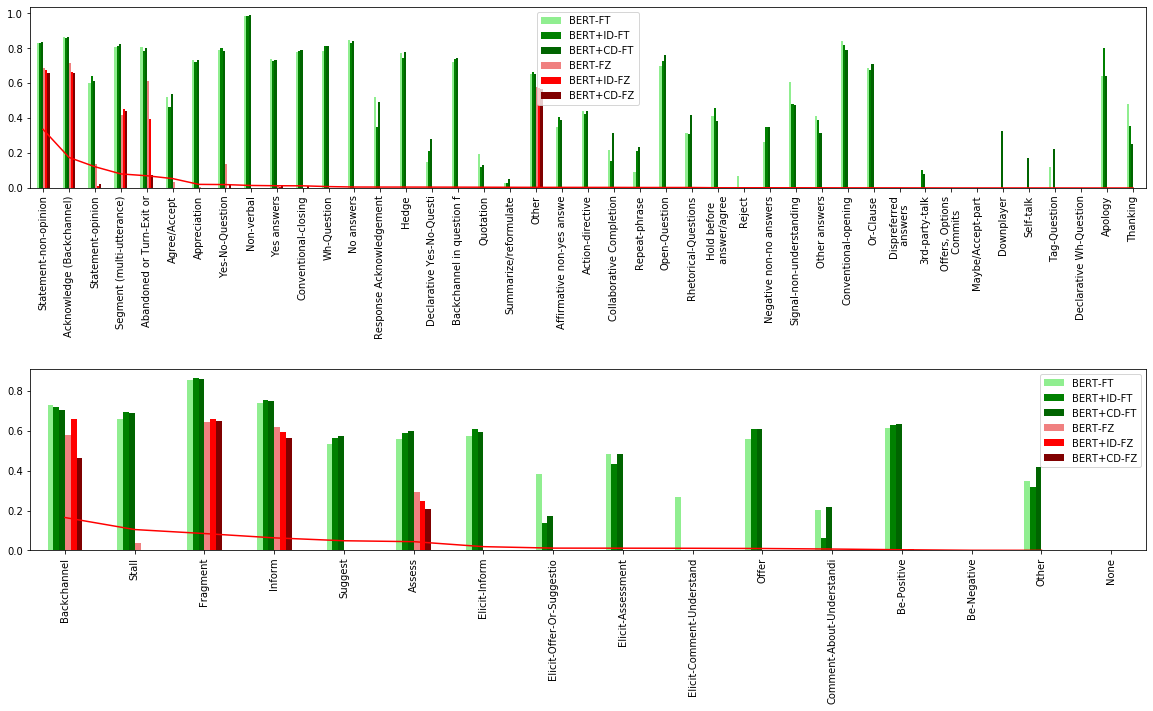

In [6]:
%matplotlib inline

colors = ['LightGreen', 'Green', 'DarkGreen', 'LightCoral', 'Red', 'Maroon']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.f1_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in conditions],
    index=conditions, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=colors)

res = pd.DataFrame([metrics.f1_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in conditions]
    , index=conditions, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=colors)

The effect of additional pre-training is mixed. For AMI it appears that in-domain pre-training offers a modest performance boost, but there is no discernable effect in the case of Switchboard. Indeed, when BERT is frozen during fine-tuning, the model that received no additional pre-traininig performs better by more than 3 percentage points. 

In [7]:
conditions = ['addl-pre', 'standard', 'addl-pre-NL', 'standard-NL']

model_dirs = [
    '../../models/SWDA-L_bert_SWBD-pre_2019-12-03/',
    '../../models/SWDA-L_bert_2019-11-20',
    '../../models/SWDA-NL_bert_SWBD-pre_2019-12-03/',
    '../../models/SWDA-NL_bert_2019-11-20']
dfs = gen_model_preds_df('SWDA', conditions, model_dirs)

model_dirs = [
    '../../models/AMI-DA-L_bert_AMI-pre_2019-12-03/',
    '../../models/AMI-DA-L_bert_2019-11-20',
    '../../models/AMI-DA-NL_bert_AMI-pre_2019-12-03/',
    '../../models/AMI-DA-NL_bert_2019-11-20']
dfa = gen_model_preds_df('AMI-DA', conditions, model_dirs)
dfa = dfa[dfa['da_tag'].notnull()]


report_metrics([dfs,dfa], conditions)

SWBD  AMI
addl-pre    macro precision  0.56 0.52
            macro recall     0.42 0.45
            macro f1         0.45 0.47
            micro accuracy   0.77 0.69
standard    macro precision  0.56 0.59
            macro recall     0.43 0.48
            macro f1         0.46 0.50
            micro accuracy   0.77 0.67
addl-pre-NL macro precision  0.56 0.55
            macro recall     0.43 0.46
            macro f1         0.46 0.48
            micro accuracy   0.77 0.68
standard-NL macro precision  0.46 0.59
            macro recall     0.37 0.46
            macro f1         0.38 0.49
            micro accuracy   0.77 0.67